# Collection of GFS Forecast Maps from Thredds Server via NCSS and Siphon

## Justin Richling
## 11/15/18

https://doi.org/10.6084/m9.figshare.5244637.v1

In [2]:
# Random Library Imports
import subprocess,os,glob,tempfile,re,webbrowser,io,sys,types,\
time

# Importing Datetime Libraries
from datetime import datetime, timedelta

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog

# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import masked_array, units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.constants import g

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# More Image Manipulation Options
from PIL import Image as PILImage
from IPython.display import Image

# Ipyhton Options
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display, Image

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap

# Warnings
import warnings
warnings.filterwarnings('ignore')


/Users/chowdahead/miniconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [13]:
# Set the font 
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

In [3]:
def create_colormap(colors, position=None, bit=False, reverse=False, name='custom_colormap'):
    """
    returns a linear custom colormap
    Parameters
    ----------
    colors : array-like
        contain RGB values. The RGB values may either be in 8-bit [0 to 255]
        or arithmetic [0 to 1] (default).
        Arrange your tuples so that the first color is the lowest value for the
        colorbar and the last is the highest.
    position : array like
        contains values from 0 to 1 to dictate the location of each color.
    bit : Boolean
        8-bit [0 to 255] (in which bit must be set to
        True when called) or arithmetic [0 to 1] (default)
    reverse : Boolean
        If you want to flip the scheme
    name : string
        name of the scheme if you plan to save it
    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        cmap with equally spaced colors
    """
    from matplotlib.colors import LinearSegmentedColormap
    if not isinstance(colors, np.ndarray):
        colors = np.array(colors, dtype='f')
    if reverse:
        colors = colors[::-1]
    if position is not None and not isinstance(position, np.ndarray):
        position = np.array(position)
    elif position is None:
        position = np.linspace(0, 1, colors.shape[0])
    else:
        if position.size != colors.shape[0]:
            raise ValueError("position length must be the same as colors")
        elif not np.isclose(position[0], 0) and not np.isclose(position[-1], 1):
            raise ValueError("position must start with 0 and end with 1")
    if bit:
        colors[:] = [tuple(map(lambda x: x / 255., color)) for color in colors]
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))
    return LinearSegmentedColormap(name, cdict, 256)

## Helper Functions

In [4]:
# Thanks to the crew over at Metpy for this handy little function
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set the Map Projection

In [5]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set a list for the 24 hour forecast time steps

In [6]:
now = datetime.utcnow()
#now = datetime(2019,2,7,18,0)
today_day = int('{0:%d}'.format(now))
today_year = int('{0:%Y}'.format(now))
today_month = int('{0:%m}'.format(now))
print(today_day,today_year,today_month)

forecast_times = []
forecast_times.append(now)
#for i in range(4,8):
#    forecast_times.append(datetime(today_year,today_month,today_day,i*3,0))
#for i in range(0,5):
#    forecast_times.append(datetime(today_year,today_month,today_day+1,i*3,0))
forecast_times

11 2019 3


[datetime.datetime(2019, 3, 11, 22, 46, 48, 874419)]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Figure out where the saved maps will go

In [ ]:
# Set a path to save the plots with string format for the date to set the month and day 
im_save_path ="/path/to/saved/images/"
print(im_save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)

# Uncomment if you want to automatically change to the map folder    
#os.chdir(im_save_path)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Start at the top of the thredds catalog

In [8]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[1]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Best GFS Quarter Degree Forecast Time Series
Path: grib/NCEP/GFS/Global_0p25deg/Best


In [9]:
colors=[(30,30,30),(50,50,50),(65,65,65),(80,80,80),(90,90,90),(100,100,100),(108,108,108),(114,114,114),
        (120,120,120),(130,130,130),(150,150,150),(180,180,180),(190,190,190),(200,200,200),(211,211,211),
        (220,220,220),(230,230,230),(244,244,244),(255, 255, 255),(255, 255, 255),(255, 255, 255),
        (230,250,230),(0, 100, 0),(50,200,50),(200,255,47),(255,255,0),(255,200,50),(255,150,80),
        (255,100,50),(255,0,0),(180,0,0),(140,0,0),(100,0,0),(150,10,0),(208,32,144),(150,32,144),
        (108,32,144),(0,0,100),(0,0,255),(0,150,150),(135,206,250)]

my_cmap = create_colormap(colors, bit=True)

<h2>----------------------------------------------//---------------------------------------------------------</h2>
<h2>----------------------------------------------//---------------------------------------------------------</h2>

<h1><font><center>-- 500mb Vorticity and Heights --</center></font></h1>

2019_03_12_00Z


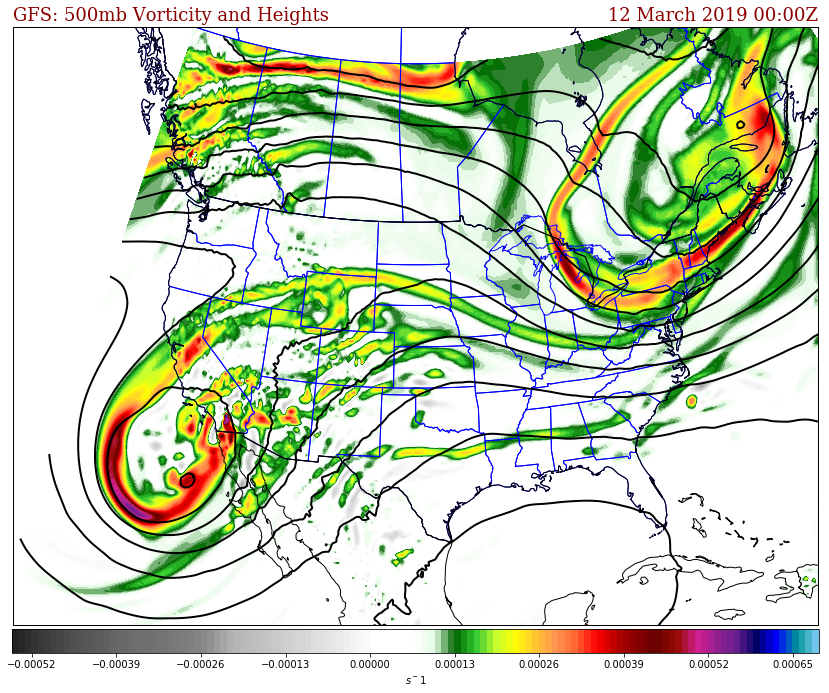

done.


In [14]:
for i in forecast_times:
    ds = gfs_cat.datasets[1]
    subset = ds.subset()
    query_data = subset.query()
    query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

    # Allow for NetCDF files
    query_data.accept('netcdf4')
    query_data.time(i)
    data = query_data.variables("Absolute_vorticity_isobaric",'Geopotential_height_isobaric')

    # Finally attempt to access the data
    data = subset.get_data(query_data)
        #for i in data.variables.keys(): print "Variables:",i,"\n"

    # Pull out variables you want to use
    Vort = data.variables['Absolute_vorticity_isobaric']
    lev_500mb = np.where(data.variables['isobaric4'][:] == 50000)[0][0]
    Vort_500 = data.variables['Absolute_vorticity_isobaric'][0, lev_500mb, :, :]

    lat = data.variables['lat'][:].squeeze()
    lon = data.variables['lon'][:].squeeze()
    time_var = data.variables[find_time_var(data.variables['Absolute_vorticity_isobaric'])]

    # Convert number of hours since the reference time into an actual date
    time_final = num2date(time_var[:].squeeze(), time_var.units)
    print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
    file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"

    # Combine 1D latitude and longitudes into a 2D grid of locations
    #lon_2d, lat_2d = np.meshgrid(lon, lat)

    # Create new figure
    fig = plt.figure(figsize=(17., 11.))

    add_metpy_logo(fig, 30, 940, size='small')

    # Add the map and set the extent
    ax = plt.subplot(111, projection=plotcrs)

    #Set the lat and lon boundaries
    ax.set_extent(extent, datacrs)

    # Add state boundaries to plot
    ax.add_feature(states_provinces, edgecolor='blue', linewidth=1)

    # Add country borders to plot
    ax.add_feature(country_borders, edgecolor='black', linewidth=1)

    # Plot Title
    plt.title('GFS: 500mb Vorticity and Heights', fontdict=font,loc='left')
    plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final), fontdict=font,loc='right')

    Min = Vort_500.min()
    Max = Vort_500.max()
    #print(Min,Max)
    
    #print hght_500.min(),hght_500.max()
    #hght_500 = ndimage.gaussian_filter(hght_500, sigma=3, order=0) * units.meter

    lev_500 = np.where(data.variables['isobaric'][:] == 50000)[0][0]
    hght_500 = data.variables['Geopotential_height_isobaric'][0, lev_500, :, :]
    MIN = hght_500.min()
    MAX = hght_500.max()
    clev500 = np.arange(MIN, MAX, 70)
    cs = ax.contour(lon, lat, hght_500,clev500 ,colors='black', linewidths=2.0,
                    linestyles='solid', transform=ccrs.PlateCarree())
    vort_levels = np.arange(-.00055,.0007,0.00001)
    cs2 = ax.contourf(lon, lat, Vort_500,vort_levels,
                     transform=datacrs,cmap=my_cmap)
    
    cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]

    #def myfmt(x, pos):
    #    return '{0:.1e}'.format(x)

    # apply formatter for colorbar labels
    #cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes,format=mpl.ticker.FuncFormatter(myfmt))
    cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes)
    
    #cbar = plt.colorbar(cs2, orientation='horizontal',cax=cbaxes,ticks = np.arange(-0.0006, 0.0006, 17),format=sfmt)
    cbar.set_label(r'$s{^-1}$')

    plt.show()
    VORT = im_save_path+"GFS/Vorticity/"
    if not os.path.isdir(VORT):
        os.makedirs(VORT)
    outfile=VORT+"Vort_Heights_500mb_"+file_time+".png"
    fig.savefig(outfile,bbox_inches='tight',dpi=120)
    plt.close(fig)
print("done.")